# https://github.com/danielvarga/string-art

In [1]:
# Bresenham line algorithm
# https://gist.github.com/flags/1132363
class bresenham:
    def __init__(self, start, end):
        self.start = list(start)
        self.end = list(end)
        self.path = []
        
        self.steep = abs(self.end[1]-self.start[1]) > abs(self.end[0]-self.start[0])
        
        if self.steep:
            self.start = self.swap(self.start[0],self.start[1])
            self.end = self.swap(self.end[0],self.end[1])
        
        if self.start[0] > self.end[0]:
            _x0 = int(self.start[0])
            _x1 = int(self.end[0])
            self.start[0] = _x1
            self.end[0] = _x0
            
            _y0 = int(self.start[1])
            _y1 = int(self.end[1])
            self.start[1] = _y1
            self.end[1] = _y0
        
        dx = self.end[0] - self.start[0]
        dy = abs(self.end[1] - self.start[1])
        error = 0
        derr = dy/float(dx)
        
        ystep = 0
        y = self.start[1]
        
        if self.start[1] < self.end[1]: ystep = 1
        else: ystep = -1
        
        for x in range(self.start[0],self.end[0]+1):
            if self.steep:
                self.path.append((y,x))
            else:
                self.path.append((x,y))
            
            error += derr
            
            if error >= 0.5:
                y += ystep
                error -= 1.0

    def swap(self,n1,n2):
        return [n2,n1]


# Bresenham circle algorithm
# https://www.daniweb.com/programming/software-development/threads/321181/python-bresenham-circle-arc-algorithm
def circle(radius):
    # init vars
    switch = 3 - (2 * radius)
    points = set()
    x = 0
    y = radius
    # first quarter/octant starts clockwise at 12 o'clock
    while x <= y:
        # first quarter first octant
        points.add((x,-y))
        # first quarter 2nd octant
        points.add((y,-x))
        # second quarter 3rd octant
        points.add((y,x))
        # second quarter 4.octant
        points.add((x,y))
        # third quarter 5.octant
        points.add((-x,y))
        # third quarter 6.octant
        points.add((-y,x))
        # fourth quarter 7.octant
        points.add((-y,-x))
        # fourth quarter 8.octant
        points.add((-x,-y))
        if switch < 0:
            switch = switch + (4 * x) + 6
        else:
            switch = switch + (4 * (x - y)) + 10
            y = y - 1
        x = x + 1
    return points


In [2]:
import sys
import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
from scipy.misc import imread, imresize, imsave
import math
from collections import defaultdict

In [3]:
def image(filename, size):
    img = imresize(imread(filename, flatten=True), (size, size))
    return img


def build_arc_adjecency_matrix(n, radius):
    print("building sparse adjecency matrix")
    hooks = np.array([[math.cos(np.pi*2*i/n), math.sin(np.pi*2*i/n)] for i in range(n)])
    hooks = (radius * hooks).astype(int)
    edge_codes = []
    row_ind = []
    col_ind = []
    for i, ni in enumerate(hooks):
        for j, nj in enumerate(hooks[i+1:], start=i+1):
            edge_codes.append((i, j))
            pixels = bresenham(ni, nj).path
            edge = []
            for pixel in pixels:
                pixel_code = (pixel[1]+radius)*(radius*2+1) + (pixel[0]+radius)
                edge.append(pixel_code)
            row_ind += edge
            col_ind += [len(edge_codes)-1] * len(edge)
    # creating the edge-pixel adjecency matrix:
    # rows are indexed with pixel codes, columns are indexed with edge codes.
    sparse = scipy.sparse.csr_matrix(([1.0]*len(row_ind), (row_ind, col_ind)), shape=((2*radius+1)*(2*radius+1), len(edge_codes)))
    return sparse, hooks, edge_codes


def build_circle_adjecency_matrix(radius, small_radius):
    print("building sparse adjecency matrix")
    edge_codes = []
    row_ind = []
    col_ind = []
    pixels = circle(small_radius)
    for i, cx in enumerate(range(-radius+small_radius+1, radius-small_radius-1, 1)):
        for j, cy in enumerate(range(-radius+small_radius+1, radius-small_radius-1, 1)):
            edge_codes.append((i, j))
            edge = []
            for pixel in pixels:
                px, py = cx+pixel[0], cy+pixel[1]
                pixel_code = (py+radius)*(radius*2+1) + (px+radius)
                edge.append(pixel_code)
            row_ind += edge
            col_ind += [len(edge_codes)-1] * len(edge)
    # creating the edge-pixel adjecency matrix:
    # rows are indexed with pixel codes, columns are indexed with edge codes.
    sparse = scipy.sparse.csr_matrix(([1.0]*len(row_ind), (row_ind, col_ind)), shape=((2*radius+1)*(2*radius+1), len(edge_codes)))
    hooks = []
    return sparse, hooks, edge_codes


def build_image_vector(img, radius):
    # representing the input image as a sparse column vector of pixels:
    assert img.shape[0] == img.shape[1]
    img_size = img.shape[0]
    row_ind = []
    col_ind = []
    data = []
    for y, line in enumerate(img):
        for x, pixel_value in enumerate(line):
            global_x = x - img_size//2
            global_y = y - img_size//2
            pixel_code = (global_y+radius)*(radius*2+1) + (global_x+radius)
            data.append(float(pixel_value))
            row_ind.append(pixel_code)
            col_ind.append(0)
    sparse_b = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=((2*radius+1)*(2*radius+1), 1))
    return sparse_b


def reconstruct(x, sparse, radius):
    b_approx = sparse.dot(x)
    b_image = b_approx.reshape((2*radius+1, 2*radius+1))
    b_image = np.clip(b_image, 0, 255)
    return b_image


def reconstruct_and_save(x, sparse, radius, filename):
    brightness_correction = 1.2
    b_image = reconstruct(x * brightness_correction, sparse, radius)
    imsave(filename, b_image)


def dump_arcs(solution, hooks, edge_codes, filename):
    f = open(filename, "w")
    f.write(f'{len(hooks)}\n')
    for i, (x, y) in enumerate(hooks):
        f.write(f'{i}\t{x}\t{y}\n')
    f.write('\n')
    assert len(edge_codes) == len(solution)
    for (i, j), value in zip(edge_codes, solution):
        if value==0:
            continue
        # int values are shown as ints.
        if value==int(value):
            value = int(value)
        f.write(f'{i}\t{j}\t{value}\n')
    f.close()

In [4]:
n = 180
radius = 250

sparse, hooks, edge_codes = build_arc_adjecency_matrix(n, radius)

building sparse adjecency matrix


In [5]:
filename = 'test3.png'
output_prefix = 'output'
shrinkage = 0.75
img = image(filename, int(radius * 2 * shrinkage))
sparse_b = build_image_vector(img, radius)

/Users/ypw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/ypw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


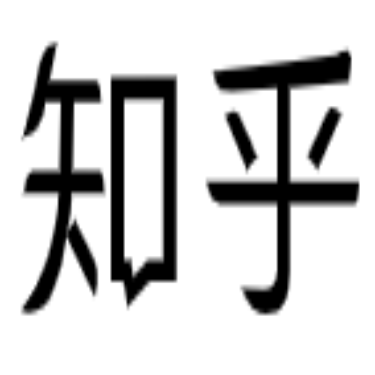

In [6]:
from IPython.display import Image
import PIL

PIL.Image.fromarray(img)

/Users/ypw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


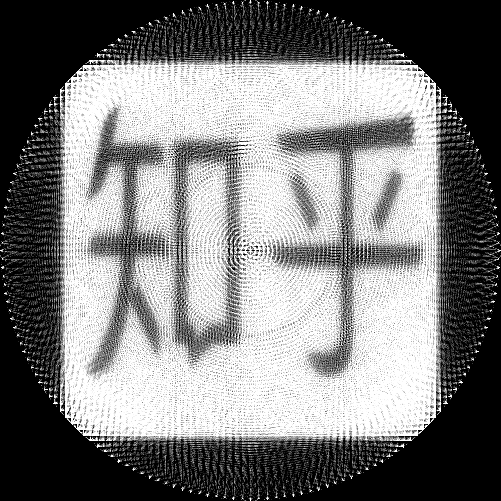

In [7]:
result = scipy.sparse.linalg.lsqr(sparse, np.array(sparse_b.todense()).flatten())
x = result[0]
reconstruct_and_save(x, sparse, radius, output_prefix+"-allow-negative.png")
dump_arcs(x, hooks, edge_codes, output_prefix+"-unquantized.txt")
Image(output_prefix+"-allow-negative.png")

/Users/ypw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


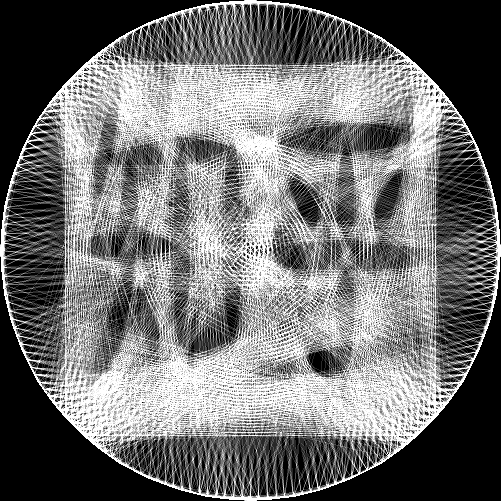

In [8]:
quantization_level = 50 # 50 is already quite good. None means no quantization.
# clip values larger than clip_factor times maximum.
# (The long tail does not add too much to percieved quality.)
clip_factor = 0.3
if quantization_level is not None:
    max_edge_weight_orig = np.max(x)
    x_quantized = (x / np.max(x) * quantization_level).round()
    x_quantized = np.clip(x_quantized, 0, int(np.max(x_quantized) * clip_factor))
    # scale it back:
    x = x_quantized / quantization_level * max_edge_weight_orig
    dump_arcs(x_quantized, hooks, edge_codes, output_prefix+".txt")

reconstruct_and_save(x, sparse, radius, output_prefix+".png")
Image(output_prefix+".png")